In [117]:
import numpy as np
import pandas as pd
import pickle
import re
import difflib 

In [118]:
df_train=pd.read_csv('dataset/train.csv')
df_test=pd.read_csv('dataset/test.csv')

In [119]:
pd.set_option('display.max_columns', None)

In [120]:
df_test['Date_of_creation']=pd.to_datetime(df_test['Date_of_creation'].values,format='%Y-%m-%d')
df_train['Date_of_creation']=pd.to_datetime(df_train['Date_of_creation'].values,format='%Y-%m-%d')

In [121]:
df_test['month']=pd.DatetimeIndex(df_test['Date_of_creation']).month
df_test['year']=pd.DatetimeIndex(df_test['Date_of_creation']).year
df_test['week']=pd.DatetimeIndex(df_test['Date_of_creation']).week

<ipython-input-121-0cf815f59879>:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_test['week']=pd.DatetimeIndex(df_test['Date_of_creation']).week


In [122]:
df_test.head()

,Deal_title,Lead_name,Industry,Deal_value,Weighted_amount,Date_of_creation,Pitch,Contact_no,Lead_revenue,Fund_category,Geography,Location,POC_name,Designation,Lead_POC_email,Hiring_candidate_role,Lead_source,Level_of_meeting,Last_lead_update,Internal_POC,Resource,Internal_rating,month,year,week
0,TitleAD16O,Bonilla Ltd Inc,Investment Bank/Brokerage,200988$,NaN,2020-04-15,Product_1,167.332.2751x989,100 - 500 Million,Category 4,India,Bhubaneshwar,sonia,Chairman/CEO/President,maureenthomas@bonilla.com,"Designer, fashion/clothing",Marketing Event,Level 1,more than a month,"Massiah,Gerard F",No,-1.0,4,2020,16
1,TitleOW6CR,"Williams, Rogers and Roach PLC",Electronics,409961$,2541758.2$,2021-01-23,Product_1,001-486-903-0711x7831,100 - 500 Million,Category 3,USA,"Coeur d'Alene, ID",Daniel Bell,CEO/Co-Founder/Chairman,danielbell@williams.com,Horticultural consultant,Marketing Event,Level 2,Up-to-date,"Smith,Keenan H",Yes,1.0,1,2021,3
2,TitleVVJQ5,"Wood, Vaughn and Morales Ltd",Banks,434433$,3041031.0$,2020-07-19,Product_1,(393)104-2610x9723,100 - 500 Million,Category 1,USA,"Portland-South Portland, ME",Andrew Davis,Chairman/Chief Innovation Officer,andrewdavis@wood.com,Information officer,Marketing Event,Level 2,Did not hear back after Level 1,"Gilley,Janine",Deliverable,5.0,7,2020,29
3,TitleUS8NA,Durham-Crawford Inc,Music,218952$,1521716.4$,2020-02-27,Product_2,(817)040-4599,100 - 500 Million,Category 1,India,Bareilly,shital,CEO/Chairman/President,charlesrivera@durhamcrawford.com,Commercial/residential surveyor,Contact Email,Level 3,more than a month,"Morsy,Omar A",No,5.0,2,2020,9
4,Title5VGWW,"Simpson, Duncan and Long LLC",Real Estate,392835$,2455218.75$,2020-10-25,Product_1,718-032-5726x76098,500 Million - 1 Billion,Category 3,USA,"Trenton, NJ",Shelly Stephenson,CEO/Co-Founder/Chairman,shellystephenson@simpson.com,Wellsite geologist,Others,Level 3,More than 2 weeks,"Morsy,Omar A",Deliverable,2.0,10,2020,43


In [123]:
Encoders=pickle.load(open('Encoders.pkl', 'rb'))

### Making Data more Clear for Analysis

In [124]:
def Preprocessing(df):
    def RemoveDollarSign(x):
        if type(x)==str:
            a=int(re.findall(r'\d+',x)[0])
            return a
        else:
            return x
    df['Weighted_amount']=df['Weighted_amount'].apply(lambda x:RemoveDollarSign(x))
    df['Deal_value']=df['Deal_value'].apply(lambda x:RemoveDollarSign(x))
    df=df.drop(['Deal_title','Contact_no','Lead_POC_email'],axis=1)
    
    ## Handling Missing Numerical value
    df['Deal_value']=df['Deal_value'].fillna(df['Deal_value'].mean())
    df['Weighted_amount']=df['Weighted_amount'].fillna(df['Weighted_amount'].mean())
    
    #Handling Missing Categorical columns
    df['Last_lead_update']=df['Last_lead_update'].apply(lambda x:'Missing' if x=='?' else x)
    df['Last_lead_update']=df['Last_lead_update'].fillna(df['Last_lead_update'].mode()[0])   # Need to tune it
    
    df['Industry']=df['Industry'].fillna(df['Industry'].mode()[0])
    df['Location']=df['Location'].fillna(df['Location'].mode()[0])
    df['Geography']=df['Geography'].fillna(df['Geography'].mode()[0])
    df['POC_name']=df['POC_name'].fillna(df['POC_name'].mode()[0])
    df['Resource']=df['Resource'].fillna(df['Resource'].mode()[0])
    
    ## For the time being- I am removing date columns from the dataset. I will consider while improving the model
    df=df.drop(['Date_of_creation'],axis=1)
    return df

In [125]:
df_train=Preprocessing(df_train)
df_test=Preprocessing(df_test)

In [126]:
x='Williams, Rogers and Roach PLC'
col='Lead_name'

In [127]:
def check_Similiarity_Train_test(x,col):
    try:
        a=df_train[x==df_train[col]][col].values[0]
        return a 
    except:
        try:
            b=difflib.get_close_matches(x,df_train[col],n=1)
            return b[0]
        except:
            c=df_train[col].mode()[0] # This can be tune
            return c
    

In [128]:
check_Similiarity_Train_test(x,col)

'Williams, Rocha and Logan PLC'

In [129]:
num_col=[col for col in df_test.columns if df_test[col].dtype!='O']
cat_col=list(set(df_test.columns)-set(num_col))

In [130]:
col_OHE=['Resource', 'Pitch', 'Lead_source', 'Geography', 'Fund_category']
col_LE=list(set(cat_col)-set(col_OHE))

In [131]:
df_test['Lead_name']=df_test['Lead_name'].apply(lambda x:check_Similiarity_Train_test(x,'Lead_name'))

In [132]:
df_test['Industry']=df_test['Industry'].apply(lambda x:check_Similiarity_Train_test(x,'Industry'))

In [133]:
df_test['POC_name']=df_test['POC_name'].apply(lambda x:check_Similiarity_Train_test(x,'POC_name'))

In [134]:
col_LE

['Level_of_meeting',
 'POC_name',
 'Lead_revenue',
 'Internal_POC',
 'Designation',
 'Lead_name',
 'Industry',
 'Last_lead_update',
 'Location',
 'Hiring_candidate_role']

In [135]:
for col in col_LE:
        df_test[col] = Encoders['L_enc_' + str(col)].transform(df_test[col])
        print(col)

Level_of_meeting
POC_name
Lead_revenue
Internal_POC
Designation
Lead_name
Industry
Last_lead_update
Location
Hiring_candidate_role


In [136]:
df_test.head()

,Lead_name,Industry,Deal_value,Weighted_amount,Pitch,Lead_revenue,Fund_category,Geography,Location,POC_name,Designation,Hiring_candidate_role,Lead_source,Level_of_meeting,Last_lead_update,Internal_POC,Resource,Internal_rating,month,year,week
0,2676,66,200988.0,1.556916e+06,Product_1,0,Category 4,India,71,5075,4,158,Marketing Event,0,10,38,No,-1.0,4,2020,16
1,6759,39,409961.0,2.541758e+06,Product_1,0,Category 3,USA,129,843,2,296,Marketing Event,1,9,51,Yes,1.0,1,2021,3
2,6884,17,434433.0,3.041031e+06,Product_1,0,Category 1,USA,434,178,5,317,Marketing Event,1,2,19,Deliverable,5.0,7,2020,29
3,982,81,218952.0,1.521716e+06,Product_2,0,Category 1,India,49,4848,1,120,Contact Email,2,10,42,No,5.0,2,2020,9
4,5760,114,392835.0,2.455218e+06,Product_1,2,Category 3,USA,551,158,2,636,Others,2,5,42,Deliverable,2.0,10,2020,43


In [137]:
Encoders

{'L_enc_Lead_revenue': LabelEncoder(),
 'L_enc_Designation': LabelEncoder(),
 'L_enc_Hiring_candidate_role': LabelEncoder(),
 'L_enc_Level_of_meeting': LabelEncoder(),
 'L_enc_Lead_name': LabelEncoder(),
 'L_enc_Industry': LabelEncoder(),
 'L_enc_POC_name': LabelEncoder(),
 'L_enc_Location': LabelEncoder(),
 'L_enc_Internal_POC': LabelEncoder(),
 'L_enc_Last_lead_update': LabelEncoder(),
 'OH_enc_': OneHotEncoder(handle_unknown='ignore', sparse=False)}

In [138]:
df2=pd.DataFrame(Encoders['OH_enc_'].transform(df_test[col_OHE]))

In [139]:
df2.index = df_test.index
df2.columns = Encoders['OH_enc_'].get_feature_names(df_test[col_OHE].columns.tolist())

In [140]:
df2.head()

,Resource_India,Resource_USA,Pitch_Cannot deliver,Pitch_Deliverable,Pitch_No,Pitch_Not enough,Pitch_We have all the requirements,Pitch_Yes,Lead_source_Contact Email,Lead_source_Marketing Event,Lead_source_Others,Lead_source_Website,Geography_Category 1,Geography_Category 2,Geography_Category 3,Geography_Category 4,Fund_category_Product_1,Fund_category_Product_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
df1=df_test.drop(col_OHE,axis=1)

In [142]:
df1.head()

,Lead_name,Industry,Deal_value,Weighted_amount,Lead_revenue,Location,POC_name,Designation,Hiring_candidate_role,Level_of_meeting,Last_lead_update,Internal_POC,Internal_rating,month,year,week
0,2676,66,200988.0,1.556916e+06,0,71,5075,4,158,0,10,38,-1.0,4,2020,16
1,6759,39,409961.0,2.541758e+06,0,129,843,2,296,1,9,51,1.0,1,2021,3
2,6884,17,434433.0,3.041031e+06,0,434,178,5,317,1,2,19,5.0,7,2020,29
3,982,81,218952.0,1.521716e+06,0,49,4848,1,120,2,10,42,5.0,2,2020,9
4,5760,114,392835.0,2.455218e+06,2,551,158,2,636,2,5,42,2.0,10,2020,43


In [143]:
df_test_final=df2.join(df1)

In [144]:
df_test_final.head()

,Resource_India,Resource_USA,Pitch_Cannot deliver,Pitch_Deliverable,Pitch_No,Pitch_Not enough,Pitch_We have all the requirements,Pitch_Yes,Lead_source_Contact Email,Lead_source_Marketing Event,Lead_source_Others,Lead_source_Website,Geography_Category 1,Geography_Category 2,Geography_Category 3,Geography_Category 4,Fund_category_Product_1,Fund_category_Product_2,Lead_name,Industry,Deal_value,Weighted_amount,Lead_revenue,Location,POC_name,Designation,Hiring_candidate_role,Level_of_meeting,Last_lead_update,Internal_POC,Internal_rating,month,year,week
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2676,66,200988.0,1.556916e+06,0,71,5075,4,158,0,10,38,-1.0,4,2020,16
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6759,39,409961.0,2.541758e+06,0,129,843,2,296,1,9,51,1.0,1,2021,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6884,17,434433.0,3.041031e+06,0,434,178,5,317,1,2,19,5.0,7,2020,29
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,982,81,218952.0,1.521716e+06,0,49,4848,1,120,2,10,42,5.0,2,2020,9
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5760,114,392835.0,2.455218e+06,2,551,158,2,636,2,5,42,2.0,10,2020,43


In [145]:
df_test_final=df_test_final.drop(['week'],axis=1)

In [156]:
model=pickle.load(open('model.pkl', 'rb'))

<AxesSubplot:ylabel='Density'>

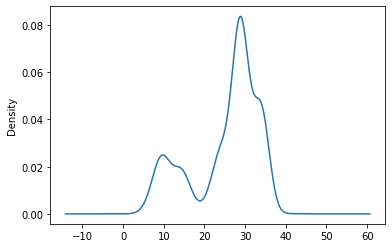

In [157]:
pred.plot.kde()

In [158]:
pred=model.predict(df_test_final)

In [159]:
pred=pd.Series(pred).apply(lambda x:0 if x<0 else x)
pred=pd.Series(pred).apply(lambda x:100 if x>100 else x)

<AxesSubplot:ylabel='Density'>

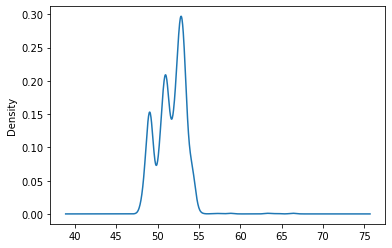

In [160]:
pred.plot.kde()

In [161]:
df_test=pd.read_csv('dataset/test.csv')

In [162]:
len(pred)

2093

In [163]:
final_dict={'Deal_title':df_test.Deal_title.values,'Success_probability':pred}

In [164]:
final_sub=pd.DataFrame(final_dict)

In [165]:
final_sub.to_csv('Submission.csv',index=False)